In [75]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.stats as st
import scipy
import pandas as pd
import os

In [77]:
###############################################################
#Define directory paths should allow for universal            #
#repo_path is the path to cloned repository                   #
#cat_folder is the path to the folder with gb_category outputs#
#work_folder is working folder for gb_mcmc outputs            #
#res_folder is path where gb_residual outputs are             #
###############################################################

repo_path = os.popen('pwd').read()
repo_path = path[:-10]
cat_folder = repo_path + 'seg_006005hz/catalog_5/'
work_folder = repo_path + 'seg_006005hz/'
res_folder = repo_path + 'seg_006005hz/residuals/'

In [78]:
#Determine if Theoretical values for quantile values have been computed
#For larger datasets the computation can take a few minutes

theory_computed = 0
detected_true = 0
for entry in os.scandir(work_folder):
    if 'theory_quantiles.dat' in entry.name:
        theory_computed = 1
    elif 'match_detected_frequency.txt' in entry.name:
        detected_true = 1
    else:
        pass

In [79]:
#Function computes CDF for a theoretical chi-squared distribution of k variables where k > 1
def analytic_norm_cdf(xvals, var, k):
  cdf = (1/scipy.special.gamma(k/2))*scipy.special.gammainc(k/2,xvals/(2*var))
  return cdf

In [80]:
#function accesses *_waveform.dat files after running GBMCMC catalog executable and adds them into a single waveform dataframe
def waveform_add(cat_folder):
    waveforms = []
    for entry in os.scandir(cat_folder):
        if 'waveform.dat' in entry.name:
            waveforms.append(entry.name)
    final_wf = pd.read_csv(cat_folder+waveforms[0],
                 names = ['Frequency',
                          'A_Re',
                          'A_Im',
                          'E_Re',
                          'E_Im'],
                delimiter = ' ')
    
    for i in range(1,len(waveforms)):
        df = pd.read_csv(cat_folder+waveforms[i],
                     names = ['Frequency',
                              'A_Re',
                              'A_Im',
                              'E_Re',
                              'E_Im'],
                    delimiter = ' ')
        final_wf = pd.merge(final_wf, df, how = 'outer', on = 'Frequency')
        final_wf = final_wf.fillna(0)
        final_wf['A_Re_x'] = final_wf['A_Re_x'].values + final_wf['A_Re_y'].values
        final_wf['A_Im_x'] = final_wf['A_Im_x'].values + final_wf['A_Im_y'].values
        final_wf['E_Re_x'] = final_wf['E_Re_x'].values + final_wf['E_Re_y'].values
        final_wf['E_Im_x'] = final_wf['E_Im_x'].values + final_wf['E_Im_y'].values

        del final_wf['A_Re_y']
        del final_wf['A_Im_y']
        del final_wf['E_Re_y']
        del final_wf['E_Im_y']

        final_wf = final_wf.rename(columns={"A_Re_x": "A_Re", "A_Im_x": "A_Im", "E_Re_x": "E_Re", "E_Im_x": "E_Im"})
        
    columns = final_wf.columns[1::]
    for i in range(len(columns)):
        final_wf[columns[i]+'^2'] = final_wf[columns[i]].values**2

    final_wf.insert(1, 'E_power', final_wf['E_Re'].values**2+final_wf['E_Im'].values**2)
    final_wf.insert(1, 'A_power', final_wf['A_Re'].values**2+final_wf['A_Im'].values**2)
        
    return final_wf

In [81]:
#Function that creates a catalog data file from the gb_catalog outputs
def detected_sources(cat_folder):
    params = []
    for entry in os.scandir(cat_folder):
        if '_params.dat' in entry.name:
            params.append(entry.name)
            
    cat_full = pd.read_csv(cat_folder+params[0],
                 index_col=False,
                 names = ['Frequency',
                          'Freq Derivative',
                          'Amplitude',
                          'Cosine CoLat',
                          'Longitude',
                          'Cosine Inclination',
                          'Psi',
                          'Phi'],
                delimiter = ' ')
    
    for i in range(1,len(params)):
        df = pd.read_csv(cat_folder+params[i],
                     index_col=False,
                     names = ['Frequency',
                              'Freq Derivative',
                              'Amplitude',
                              'Cosine CoLat',
                              'Longitude',
                              'Cosine Inclination',
                              'Psi',
                              'Phi'],
                    delimiter = ' ')
        cat_full = pd.concat([cat_full, df], axis=0, join='outer', ignore_index=True)
        cat_full.to_csv(work_folder+'catsegment.dat', index = False, columns = cat_full.columns.values, sep = ' ', header = False)
    return cat_full

In [82]:
#Read in Residual data from mcmc output files power_residual_t0_f0.dat and variance_residual_t0_f0.dat then combines into single DataFrame
fdf = pd.read_csv(work_folder+'data/power_residual_t0_f0.dat', 
                  sep = ' ',
                  index_col=False,
                  names = ['Frequency',
                           'Median A residual',
                           '25 A residual',
                           '75 A residual',
                           '5 A residual',
                           '95 A residual',
                           'Median E residual',
                           '25 E residual',
                           '75 E residual',
                           '5 E residual',
                           '95 E residual'])

rdf = pd.read_csv(work_folder+'data/variance_residual_t0_f0.dat',
                  sep = ' ',
                  index_col=False,
                  names = ['Frequency',
                           'A residual variance',
                           'E residual variance'])

fdf = pd.merge(fdf, rdf, how = 'outer', on = 'Frequency')

In [83]:
################################################################################################
#For data points with little or no change during the MCMC run residual statistics are useless  #
#this filters out those bad data points by testing against the 95 to 50 percent quantile ration#
#if the ratio derived from data is greater than half the expected value given theory, the data #
#point is filtered out                                                                         #
################################################################################################

conf_levels = [.25,.5,.75,.95]
rvals = [np.log(1-conf_levels[i])/np.log(1-.50) for i in range(1,4)]

var95_25 = fdf['95 A residual'].values/fdf['Median A residual'].values
var75_25 = fdf['75 A residual'].values/fdf['25 A residual'].values
var50_25 = fdf['Median A residual'].values/fdf['25 A residual'].values

factor = 2.0
valid_q95 = np.where((var95_25 >= rvals[2]/2))[0]
valid_q25 = valid_q95


r25_50 = fdf['25 A residual'].values[valid_q95]/fdf['Median A residual'].values[valid_q95]
r25_75 = fdf['25 A residual'].values[valid_q95]/fdf['75 A residual'].values[valid_q95]
r25_95 = fdf['25 A residual'].values[valid_q95]/fdf['95 A residual'].values[valid_q95]

[1.0, 2.0, 4.321928094887361]
[ 0  1  2  3  4  5  6  7  8  9 10 11 27 28 29 30 31 32 33 35 41 42 43]


In [84]:
#Computes Theoretical values of different quantiles based variance output in variance_residual_t0_f0.dat
#If the data file is alread present reads those values into a seperate dataframe

if theory_computed == 0:
    theory25 = []
    theory50 = []
    theory75 = []
    theory95 = []
    theory25_1 = []
    theory50_1 = []
    theory75_1 = []
    theory95_1 = []
    for i in range(len(fdf['A residual variance'].values)):
        var = fdf['A residual variance'].values[i]

        if var == 0.0 or np.isnan(var) == True:
            theory25.append(0)
            theory50.append(0)
            theory75.append(0)
            theory95.append(0)
            theory25_1.append(0)
            theory50_1.append(0)
            theory75_1.append(0)
            theory95_1.append(0)
        else:
            sig = np.sqrt(var)
            k = 2
            xvals = np.arange(0,(4*sig)**2,.001*sig**2)
            norm_analytic = analytic_norm_cdf(xvals, var, k)
            variable_1 = scipy.special.erf(np.sqrt(xvals/(2*var)))
            theory25.append(xvals[np.where((norm_analytic > .25) & (norm_analytic < .26))[0][0]])
            theory50.append(xvals[np.where((norm_analytic > .5) & (norm_analytic < .51))[0][0]])
            theory75.append(xvals[np.where((norm_analytic > .75) & (norm_analytic < .76))[0][0]])
            theory95.append(xvals[np.where((norm_analytic > .95) & (norm_analytic < .96))[0][0]])
            theory25_1.append(xvals[np.where((variable_1 > .25) & (variable_1 < .26))[0][0]])
            theory50_1.append(xvals[np.where((variable_1 > .5) & (variable_1 < .51))[0][0]])
            theory75_1.append(xvals[np.where((variable_1 > .75) & (variable_1 < .76))[0][0]])
            theory95_1.append(xvals[np.where((variable_1 > .95) & (variable_1 < .96))[0][0]])

    theory25 = np.array(theory25)
    theory50 = np.array(theory50)
    theory75 = np.array(theory75)
    theory95 = np.array(theory95)
    theory25_1 = np.array(theory25_1)
    theory50_1 = np.array(theory50_1)
    theory75_1 = np.array(theory75_1)
    theory95_1 = np.array(theory95_1)
    ind25 = np.where(theory25 != 0.0)[0]
    ind50 = np.where(theory50 != 0.0)[0]
    ind75 = np.where(theory75 != 0.0)[0]
    ind95 = np.where(theory95 != 0.0)[0]
    ind25_1 = np.where(theory25_1 != 0.0)[0]
    ind50_1 = np.where(theory50_1 != 0.0)[0]
    ind75_1 = np.where(theory75_1 != 0.0)[0]
    ind95_1 = np.where(theory95_1 != 0.0)[0]

    theory_data = np.array([theory25, theory50, theory75, theory95, theory25_1, theory50_1, theory75_1, theory95_1])
    theory_string = ['theory25', 'theory50', 'theory75', 'theory95', 'theory25_1', 'theory50_1', 'theory75_1', 'theory95_1']
    tdf = pd.DataFrame(theory_data.T, columns = theory_string)
    tdf.to_csv(work_folder+'theory_quantiles.dat', index = False, columns = theory_string, sep = ' ', header = False)

elif theory_computed == 1:
    #Obtain previously calculated Theoretical quantile values
    tdf = pd.read_csv(work_folder+'theory_quantiles.dat',
                      names = ['theory25',
                               'theory50',
                               'theory75',
                               'theory95',
                               'theory25_1',
                               'theory50_1',
                               'theory75_1',
                               'theory95_1'],
                     delimiter = ' ')
    theory25 = np.array(tdf['theory25'].values)
    theory50 = np.array(tdf['theory50'].values)
    theory75 = np.array(tdf['theory75'].values)
    theory95 = np.array(tdf['theory95'].values)
    theory25_1 = np.array(tdf['theory25_1'].values)
    theory50_1 = np.array(tdf['theory50_1'].values)
    theory75_1 = np.array(tdf['theory75_1'].values)
    theory95_1 = np.array(tdf['theory95_1'].values)

In [85]:
#Creates a dataframe for the outputs from running gb_residual executable
#Adds columns for the square of the componants and the total power

res_df = pd.read_csv(res_folder+'galaxy_data_AE_clean.dat',
                 names = ['Frequency',
                          'A_Re',
                          'A_Im',
                          'E_Re',
                          'E_Im'],
                delimiter = ' ')

columns = res_df.columns[1::]
for i in range(len(columns)):
    res_df[columns[i]+'^2'] = res_df[columns[i]].values**2
    
res_df.insert(1, 'E_res', np.array(res_df['E_Re'].values)**2+np.array(res_df['E_Im'].values)**2)
res_df.insert(1, 'A_res', np.array(res_df['A_Re'].values)**2+np.array(res_df['A_Im'].values)**2)

In [86]:
#If a catalog file has been generated alreay this portion reads in the file
#If no catalog file has been created this creates the file and generates the datafram

if detected_true == 1:
    #read in matched frequencies indices for detected sources
    det_index = np.genfromtxt(work_folder+'match_detected_frequency.txt', delimiter = ' ')
    detections = pd.read_csv(work_folder+'catsegment.dat', 
                             index_col=False,
                             names = ['Frequency',
                              'Freq Derivative',
                              'Amplitude',
                              'Cosine CoLat',
                              'Longitude',
                              'Cosine Inclination',
                              'Psi',
                              'Phi'],
                             delimiter = ' ')
    
elif detected_true == 0:
    detections = detected_sources(cat_folder)
    freqs = fdf['Frequency'].values
    det_freq = detections['Frequency'].values
    det_index = []
    det_index_m1 = []

    for j in range(len(det_freq)):
        for i in range(1,len(freqs)):
            if det_freq[j] > freqs[i-1] and det_freq[j] < freqs[i]:
                det_index_m1.append(i-1)
                det_index.append(i)
                
    di = open(work_folder+'match_detected_frequency.txt', 'w+')
    np.array(det_index).tofile(di, sep = ' ')
    di.close()

In [87]:
#Find indices in theoretical data that are non-zero
ind25 = np.where(theory25 != 0.0)[0]
ind50 = np.where(theory50 != 0.0)[0]
ind75 = np.where(theory75 != 0.0)[0]
ind95 = np.where(theory95 != 0.0)[0]
ind25_1 = np.where(theory25_1 != 0.0)[0]
ind50_1 = np.where(theory50_1 != 0.0)[0]
ind75_1 = np.where(theory75_1 != 0.0)[0]
ind95_1 = np.where(theory95_1 != 0.0)[0]

In [88]:
#Generate the full waveform from gb_catalog outputs
final_wf = waveform_add(cat_folder)

In [89]:
#Create a dataframe for initial inputs used by gb_mcmc
#data_0_0.dat is the output file from the MCMC

#data_file = 'input_data.dat'
#delim = '    '

data_file = 'data_0_0.dat'
delim = ' '

power_df = pd.read_csv(work_folder+'data/'+data_file,
                       engine = 'python',
                       delimiter = delim,
                       index_col=False,
                       names = ['Frequency',
                                'A_Re',
                                'A_Im',
                                'E_Re',
                                'E_Im'])

columns = power_df.columns[1::]
for i in range(len(columns)):
    power_df[columns[i]+'^2'] = power_df[columns[i]].values**2
    
power_df.insert(1, 'E_power', np.array(power_df['E_Re'].values)**2+np.array(power_df['E_Im'].values)**2)
power_df.insert(1, 'A_power', np.array(power_df['A_Re'].values)**2+np.array(power_df['A_Im'].values)**2)


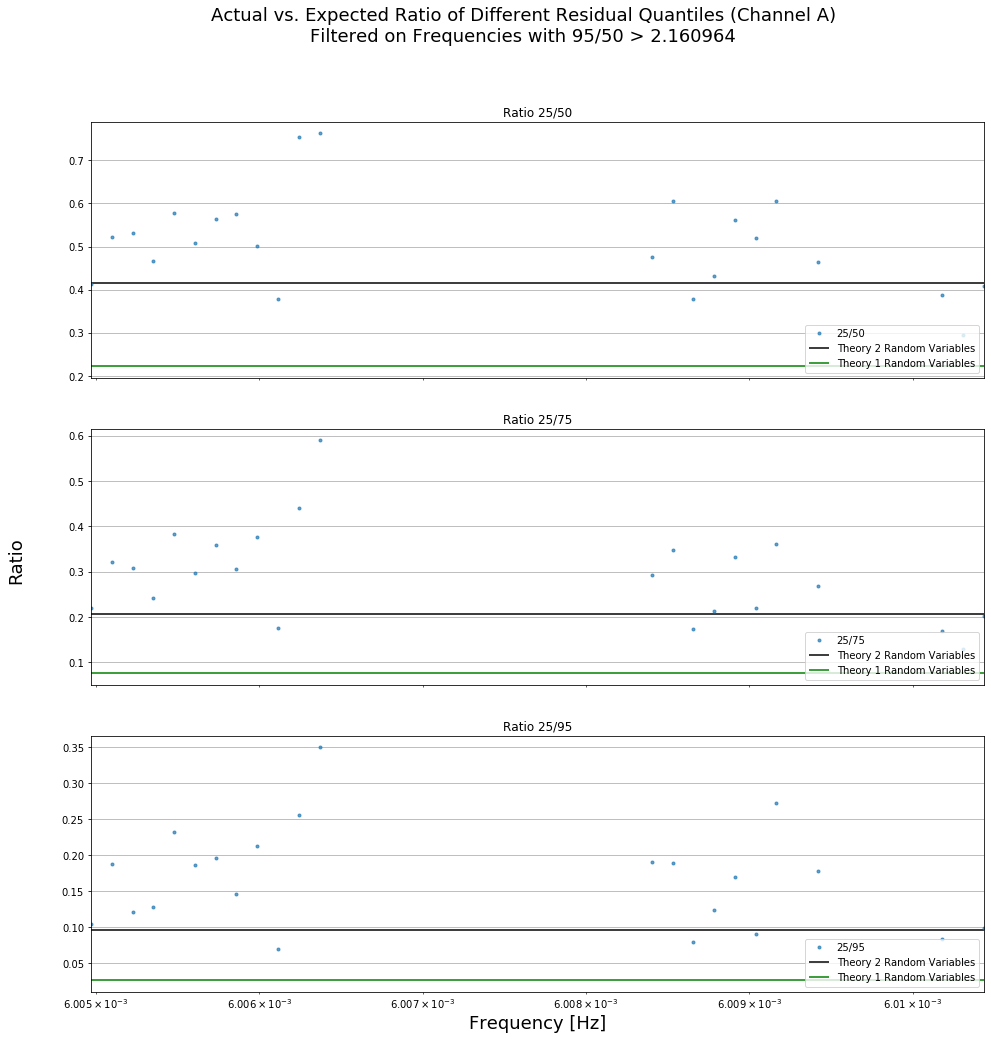

In [90]:
#Generate a plot of of various quantile ratios for the filtered statistical data.
#Compares to expected ratio value given theory

ratio25 = [np.log(1-.25)/np.log(1-conf_levels[i]) for i in range(1,4)]
ratio25_1 = [(scipy.special.erfinv(.25)**2)/(scipy.special.erfinv(conf_levels[i])**2) for i in range(1,4)]

fig , (ax0,ax1,ax2) = plt.subplots(3, 1, figsize = (16,16), sharex = True)
freqs = fdf['Frequency'].values[valid_q95]

tag = 'data_filter'

a1 = .7
ax0.plot(freqs, r25_50, '.',  alpha = a1, label = '25/50')
ax0.hlines(ratio25[0],.0001,.027, color = 'k', label = 'Theory 2 Random Variables')
ax0.hlines(ratio25_1[0],.0001,.027, color = 'g', label = 'Theory 1 Random Variables')
#ax0.set_ylim(ratio25[0]-ystep,ratio25[0]+ystep)
ax0.grid('on')
ax0.set_xscale('log')
ax0.set_xlim(np.min(freqs),np.max(freqs))
ax0.set_title('Ratio 25/50')
ax0.legend(loc=4)

ax1.plot(freqs,r25_75, '.', alpha = a1, label = '25/75')
ax1.hlines(ratio25[1],.0001,.027, color = 'k', label = 'Theory 2 Random Variables')
ax1.hlines(ratio25_1[1],.0001,.027, color = 'g', label = 'Theory 1 Random Variables')
ax1.set_title('Ratio 25/75')
ax1.set_xscale('log')
ax1.set_xlim(np.min(freqs),np.max(freqs))
ax1.grid('on')
#ax1.set_ylim(ratio25[1]-ystep,ratio25[1]+ystep)
ax1.legend(loc=4)

ax2.plot(freqs,r25_95, '.', alpha = a1 ,label = '25/95')
ax2.hlines(ratio25[2],.0001,.027, color = 'k', label = 'Theory 2 Random Variables')
ax2.hlines(ratio25_1[2],.0001,.027, color = 'g', label = 'Theory 1 Random Variables')
ax2.set_title('Ratio 25/95')
ax2.set_xscale('log')
ax2.set_xlim(np.min(freqs),np.max(freqs))
ax2.grid('on')
#ax2.set_ylim(ratio25[2]-ystep,ratio25[2]+ystep)
ax2.legend(loc=4)

plt.suptitle('Actual vs. Expected Ratio of Different Residual Quantiles (Channel A)\nFiltered on Frequencies with 95/50 > %f' % (rvals[2]/2), fontsize = 18)
fig.text(0.06, 0.5, 'Ratio', ha='center', va='center', rotation='vertical', fontsize = 18)
plt.xlabel('Frequency [Hz]', fontsize = 18)
plt.show()
fig.savefig('/home/ben/plots/'+tag+'_ratio_plot_A.png')

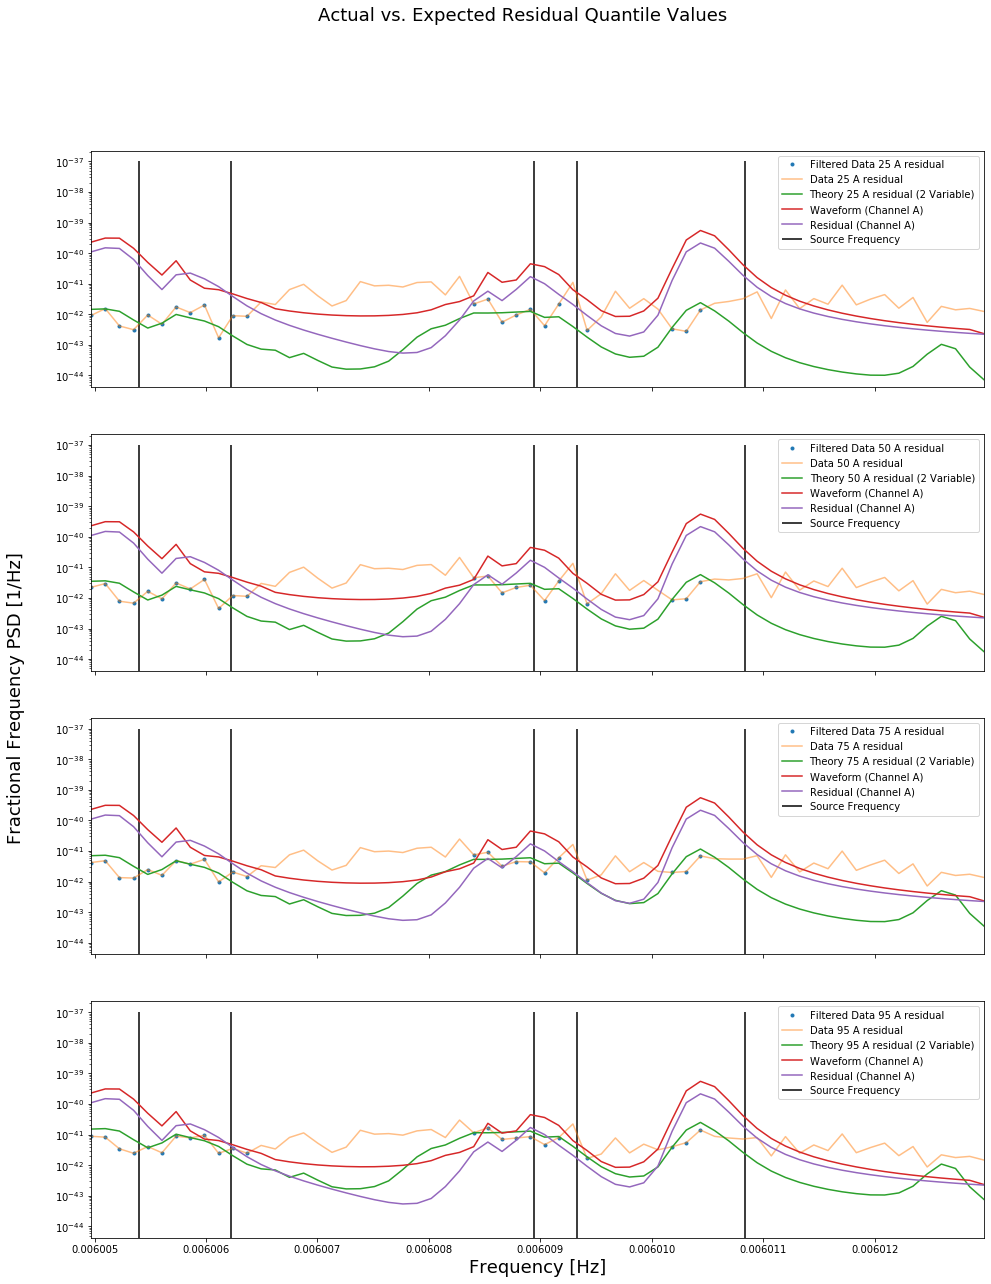

In [91]:
#############################################################
#Creates plot of various aspects for the residual data      #
#Shown are the actual quantile values generated by gb_mcmc  #
#also are shown the values for filtered data, and the values#
#expected given teh variance outputs from gb_mcmc. The      #
#complete waveform is also shown and the power computed from#
#the gb_residual outputs. Verticle lines are at frequencies # 
#identified as sources in the catalog .                     #
#############################################################

Zoom = 1
a1 = 1
a2 = .6
a3 = .3
a4 = .5

xmin = np.min(fdf['Frequency'].values)
xmax = np.max(fdf['Frequency'].values)

tag =''
fltr = '_filter'
if Zoom == 1:
    xzoom = (xmin,xmax)
    #xzoom = (.00096,.001)
    tag = '_zoom'
    fltr = '_filter'
    a2 = 1
    a3 = 1

det_freq = detections['Frequency']
fig , (ax0,ax1,ax2,ax3) = plt.subplots(4, 1, figsize = (16,20), sharex = True, sharey = True)
freqs = fdf['Frequency'].values

ax0.plot(fdf['Frequency'].values[valid_q25],fdf['25 A residual'].values[valid_q25], '.', label = 'Filtered Data 25 A residual')
ax0.plot(fdf['Frequency'].values,fdf['25 A residual'].values, alpha = a4, label = 'Data 25 A residual')
ax0.plot(freqs[ind25], theory25[ind25], alpha = a2, label = 'Theory 25 A residual (2 Variable)')
#ax0.plot(freqs[ind25], theory25_1[ind25], alpha = a3, label = 'Theory 25 A residual (1 Variable)')
final_wf.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax0, label = 'Waveform (Channel A)')
res_df.plot(x = 'Frequency', y = 'A_res', style = '-', ax = ax0, label = 'Residual (Channel A)')
ax0.vlines(det_freq, 0, 1e-37, label = 'Source Frequency')
ax0.legend(loc = 'best')
ax0.set_yscale('log')

ax1.plot(fdf['Frequency'].values[valid_q25],fdf['Median A residual'].values[valid_q25], '.',label = 'Filtered Data 50 A residual')
ax1.plot(fdf['Frequency'].values,fdf['Median A residual'].values, alpha = a4, label = 'Data 50 A residual')
ax1.plot(freqs[ind50], theory50[ind50], alpha = a2, label = 'Theory 50 A residual (2 Variable)')
#ax1.plot(freqs[ind50], theory50_1[ind50], alpha = a3, label = 'Theory 50 A residual (1 Variable)')
final_wf.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax1, label = 'Waveform (Channel A)')
res_df.plot(x = 'Frequency', y = 'A_res', style = '-', ax = ax1, label = 'Residual (Channel A)')
ax1.vlines(det_freq, 0, 1e-37, label = 'Source Frequency')
ax1.legend(loc = 'best')
ax1.set_yscale('log')

ax2.plot(fdf['Frequency'].values[valid_q25],fdf['75 A residual'].values[valid_q25], '.', label = 'Filtered Data 75 A residual')
ax2.plot(fdf['Frequency'].values,fdf['75 A residual'].values, alpha = a4, label = 'Data 75 A residual')
ax2.plot(freqs[ind75], theory75[ind75], alpha = a2, label = 'Theory 75 A residual (2 Variable)')
#ax2.plot(freqs[ind75], theory75_1[ind75], alpha = a3, label = 'Theory 75 A residual (1 Variable)')
final_wf.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax2, label = 'Waveform (Channel A)')
res_df.plot(x = 'Frequency', y = 'A_res', style = '-', ax = ax2, label = 'Residual (Channel A)')
ax2.vlines(det_freq, 0, 1e-37, label = 'Source Frequency')
ax2.legend(loc = 'best')
ax2.set_yscale('log')

ax3.plot(fdf['Frequency'].values[valid_q25],fdf['95 A residual'].values[valid_q25], '.', label = 'Filtered Data 95 A residual')
ax3.plot(fdf['Frequency'].values,fdf['95 A residual'].values, alpha = a4, label = 'Data 95 A residual')
ax3.plot(freqs[ind95], theory95[ind95], alpha = a2, label = 'Theory 95 A residual (2 Variable)')
#ax3.plot(freqs[ind95], theory95_1[ind95], alpha = a3, label = 'Theory 95 A residual (1 Variable)')
final_wf.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax3, label = 'Waveform (Channel A)')
res_df.plot(x = 'Frequency', y = 'A_res', style = '-', ax = ax3, label = 'Residual (Channel A)')
ax3.vlines(det_freq, 0, 1e-37, label = 'Source Frequency')
ax3.legend(loc = 'best')
ax3.set_yscale('log')

if Zoom == 1:
    plt.xlim(xzoom)

plt.xlabel('Frequency [Hz]', fontsize = 18)
fig.text(0.06, 0.5, 'Fractional Frequency PSD [1/Hz]', ha='center', va='center', rotation='vertical', fontsize = 18)
plt.suptitle("Actual vs. Expected Residual Quantile Values", fontsize = 18)
plt.show()

fig.savefig(work_folder+'quantiles'+tag+fltr+'.png')

In [92]:
############################################################################
#Manually compute residuals by taking input power and subtracting waveform #
#if done by component, subtracts individual real and imaginary parts before#
#computing a power residual. If done by power, directly subtracts the power#
#of the waveform from the power of the inputs.                             #
############################################################################

by_components = 1
by_power = 0

if by_components == 1:
    freqs = final_wf['Frequency'].values
    cols = final_wf.columns.values
    res_ar = np.array(power_df['A_Re'].values)-np.array(final_wf['A_Re'].values)
    res_ai = np.array(power_df['A_Im'].values)-np.array(final_wf['A_Im'].values)
    res_er = np.array(power_df['E_Re'].values)-np.array(final_wf['E_Re'].values)
    res_ei = np.array(power_df['E_Im'].values)-np.array(final_wf['E_Im'].values)
    
    res_ar_power = res_ar**2
    res_ai_power = res_ai**2
    res_er_power = res_er**2
    res_ei_power = res_ei**2

    res_power_a = res_ar**2 + res_ai**2
    res_power_e = res_er**2 + res_ei**2
    
    residual_df = pd.DataFrame(np.array([freqs, res_power_a, res_power_e, res_ar, res_ai, res_er, res_ei, res_ar_power, res_ai_power, res_er_power, res_ei_power]).T, columns = cols)

if by_power == 1:
    res_power_a = np.array(power_df['A_power'].values)-np.array(final_wf['A_power'].values)
    res_power_e = np.array(power_df['E_power'].values)-np.array(final_wf['E_power'].values)

    
residual_df

,Frequency,A_power,E_power,A_Re,A_Im,E_Re,E_Im,A_Re^2,A_Im^2,E_Re^2,E_Im^2
0,0.006005,2.975812e-41,5.351270e-40,1.362089e-21,5.282313e-21,-1.464456e-20,1.790709e-20,1.855287e-42,2.790283e-41,2.144630e-40,3.206640e-40
1,0.006005,5.388309e-41,6.702665e-40,-5.765692e-21,-4.543114e-21,1.587424e-20,-2.045177e-20,3.324320e-41,2.063988e-41,2.519915e-40,4.182750e-40
2,0.006005,8.085582e-40,5.078140e-41,-1.662963e-20,2.306542e-20,-6.972832e-21,1.470042e-21,2.765446e-40,5.320136e-40,4.862038e-41,2.161023e-42
3,0.006005,6.910115e-41,4.277680e-40,-1.428757e-21,8.189005e-21,-1.272124e-20,1.630761e-20,2.041347e-42,6.705980e-41,1.618300e-40,2.659380e-40
4,0.006005,4.711458e-42,2.435786e-40,2.168749e-21,8.936450e-23,-7.964405e-21,1.342188e-20,4.703472e-42,7.986014e-45,6.343175e-41,1.801468e-40
...,...,...,...,...,...,...,...,...,...,...,...
59,0.006012,1.654133e-43,1.471155e-43,4.028017e-22,5.625060e-23,2.219735e-22,-3.127990e-22,1.622492e-43,3.164130e-45,4.927224e-44,9.784321e-44
60,0.006013,3.980609e-42,4.956520e-42,1.874719e-21,-6.826695e-22,-2.002564e-21,-9.727580e-22,3.514571e-42,4.660376e-43,4.010262e-42,9.462581e-43
61,0.006013,8.624238e-43,9.244415e-42,-7.583099e-22,-5.360876e-22,1.524823e-21,2.630462e-21,5.750339e-43,2.873899e-43,2.325084e-42,6.919330e-42
62,0.006013,3.046490e-42,1.774521e-42,-2.265077e-22,-1.730660e-21,3.558832e-22,1.283693e-21,5.130575e-44,2.995185e-42,1.266529e-43,1.647868e-42


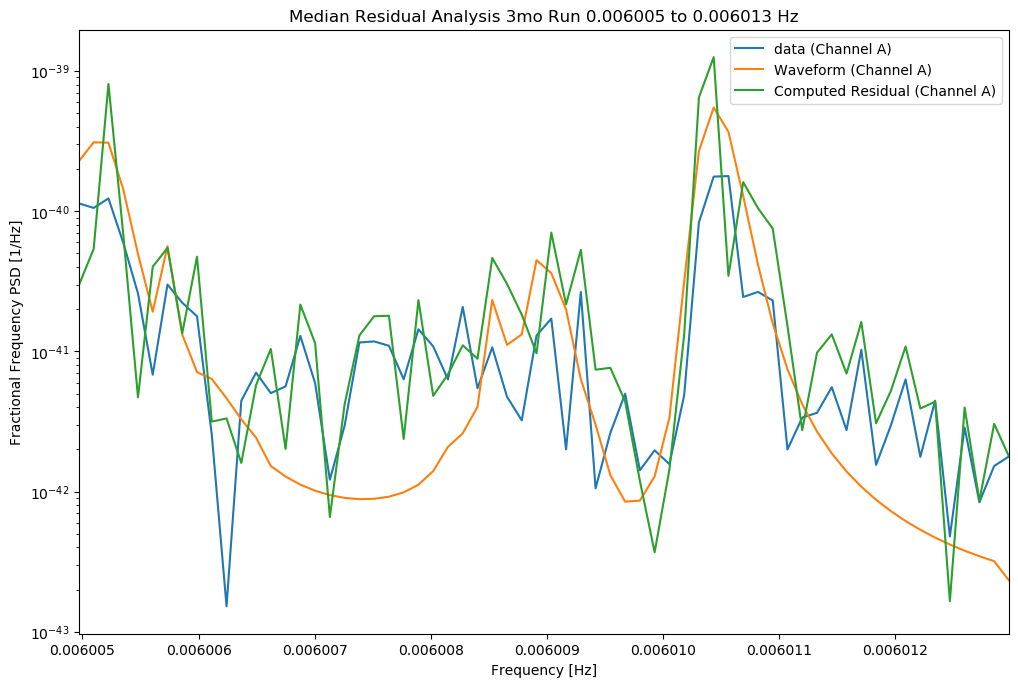

In [93]:
#Create plot of input data power, waveform, and computed residual
#res_df will display data from gb_residual output

fig = plt.figure(figsize = [12,8],dpi=100)
ax1 = plt.axes()

#ax1.plot(fdf['Frequency'].values[valid_q25],fdf['Median A residual'].values[valid_q25], '.',label = 'Filtered Data 50 A residual')
#ax1.plot(fdf['Frequency'].values,fdf['Median A residual'].values, alpha = a4, label = 'Data 50 A residual')
#ax1.plot(freqs[ind50], theory50[ind50], alpha = a2, label = 'Theory 50 A residual (2 Variable)')
#ax1.plot(freqs[ind50], theory50_1[ind50], alpha = a3, label = 'Theory 50 A residual (1 Variable)')
power_df.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax1, label = 'data (Channel A)')
final_wf.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax1, label = 'Waveform (Channel A)')
#res_df.plot(x = 'Frequency', y = 'A_res', style = '-', ax = ax1, label = 'Residual (Channel A)')
residual_df.plot(x = 'Frequency', y = 'A_power', style = '-', ax = ax1, label = 'Computed Residual (Channel A)')
#ax1.vlines(det_freq, 0, 1e-37, label = 'Source Frequency')
ax1.legend(loc = 'best')
ax1.set_yscale('log')
plt.xlim(xmin,xmax)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Fractional Frequency PSD [1/Hz]')
plt.title('Median Residual Analysis 3mo Run %f to %f Hz' % (xmin,xmax))
plt.show()